# Lab 6 - How do we locate disease causing mutations?
## Combinatorial Pattern Matching
Material and embedded lab.

Motivation and some exercises are variations on those available in Bioinformatics Algorithms: An Active-Learning Approach by Phillip Compeau & Pavel Pevzner.

In [1]:
debug = True # Set this to False before pushing to be graded
display_available = True
try:
    display('Verifying you can use display')
    from IPython.display import Image
except:
    display_available = False
try:
    import pygraphviz
    graphviz_installed = True # Set this to False if you don't have graphviz
except:
    graphviz_installed = False

'Verifying you can use display'

# What causes Ohdo Syndrome?

* Ohdo syndrome causes expressionless, "mask-like" face
* 2011 - biologists found a handful of mutations shared by multiple patients that then identified a single protein-truncating mutation responsible for Ohdo syndrome
* How can we study this in bioinformatics? 
    * Read mapping
    * Single nucleotide polymorphisms (SNPs)

<img src="https://online.stat.psu.edu/stat555/sites/onlinecourses.science.psu.edu.stat555/files/snps/snps_reads_02/index.png">

## Why not use the algorithms we already have?

* Why not just assemble each persons genome? 
   * Expensive and error prone
* Other sequence alignment algorithms become runtime bottlenecks when we scale to millions of reads
* And finally, we can solve the problem in a more efficient way, so we should...

## Introduction to Multiple Pattern Matching
* Reads are a few hundred base pairs long
* When hunting for a cause of a genetic disorder, we can immediately eliminate areas of reference genome with exact matches

*Multiple Pattern Matching Problem:*

Input: ``text`` and a collection of ``patterns`` (shorter strings)

Output: All starting positions in ``text`` where a string from ``patterns`` appears as a substring.

*Brute force solution*
* Consider each pattern as its own car driving down a road (``text``)
* It would work but as we move each pattern down the same ``text`` we realize how inefficent this is: $O(|text|*|patterns|)$ ... brutal

## Herding Patterns into a trie
Trie - directed acyclic graph written ``trie(patterns)`` has the following properties:
* Single root node with indegree of 0; all other nodes have indegree of 1
* Each edge of ``trie(patterns)`` is labeled with a letter of the alphabet
* Edges leading out a given node have distinct labels
* Every string in ``patterns`` is spelled out by concatenating the letters along some path from the root downward
* Every path from the root to a leaf spells a string from ``patterns``.

**Exercise 1**: Trie construction problem - Construct a trie from a collection of patterns

Input: A collection of strings (``patterns``)

Output: ``trie(patterns)`` in the form a networkx direct graph.

In [2]:
# For the record here is what worked for me. I think it is worth it to get graphviz working for you, but it can
# be a pain... I'm using a Mac
#!sudo chown -R $(whoami) /usr/local/lib/pkgconfig
#!chmod u+w /usr/local/lib/pkgconfig
#!brew install graphviz
#!            pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"

In [3]:
!pip install pygraphviz

In [4]:
# Just code to help you out here
%matplotlib inline

import networkx as nx
import pandas as pd
import copy

import matplotlib.pyplot as plt

def draw(A):
    return Image(A.draw(format='png', prog='dot'))

def to_adj(T):
    df = pd.DataFrame(nx.adjacency_matrix(T).todense(),index=T.nodes(),columns=T.nodes())
    for i in range(len(df)):
        for j in range(len(df)):
            if df.iloc[i,j] == 1:
                data = T.get_edge_data(df.index[i],df.columns[j])
                df.iloc[i,j] = data['label']
            else:
                df.iloc[i,j] = ""
    return df

def show(G):
    if graphviz_installed:
        # same layout using matplotlib with no labels
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        #print(edge_labels)
        # Modify node fillcolor and edge color.
        #D.node_attr.update(color='blue', style='filled', fillcolor='yellow')
        #D.edge_attr.update(color='blue', arrowsize=1)
        A = nx.nx_agraph.to_agraph(G)
        # draw it in the notebook
        if display_available:
            display(draw(A))
        else:
            print(A)
    else:
        if display_available:
            display(to_adj(G))
        else:
            print(to_adj(G))

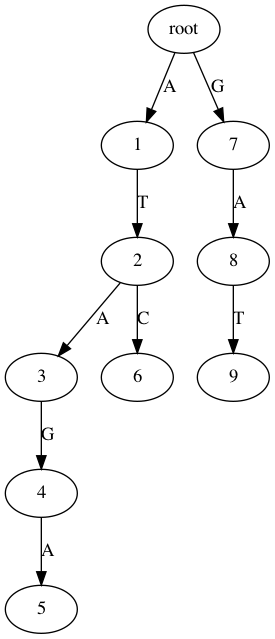

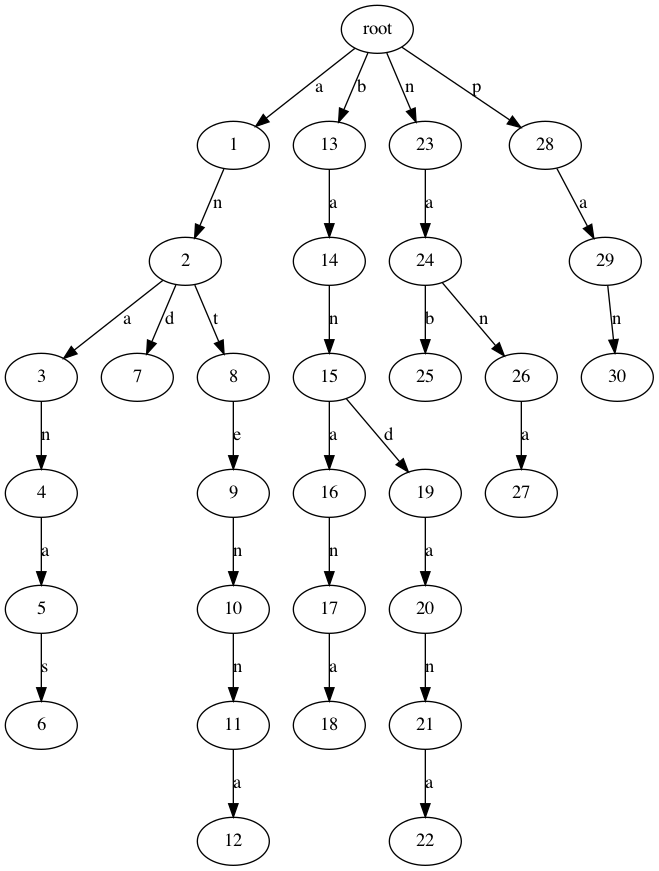

In [5]:
import networkx as nx

# Inputs: G - networkx graph, current - node name, c - character on edge
# Output: a neighbor of current that is reached by an edge that has label==c; otherwise None
def find_edge(G,current,c): 
    for n in G.neighbors(current):
        if n is None:
            return None
        data = G.get_edge_data(current,n)
        if data['label'] == c:
            return n
    return None

def trie_construction(patterns):
    G = nx.DiGraph()
    G.add_node('root')
    # Your solution here
    return G

patterns1 = ['ATAGA','ATC','GAT']
trie1 = trie_construction(patterns1)
show(trie1)

patterns2 = ['ananas','and','antenna','banana','bandana','nab','nana','pan']
trie2 = trie_construction(patterns2)
show(trie2)

*Applying the trie to multiple pattern matching*

Given a string ``text`` and ``trie(patterns)``, it is easy to see if a prefix of ``text`` matches any of our patterns. 

We just need to simply work through the graph. If we get to a leaf node, then we can output the path from the root to the leaf node.

In [6]:
def prefix_trie_matching(text,trie):
    symbol = text[0]
    v = "root"
    i = 1
    while i < len(text):            
        if len(list(trie.neighbors(v))) == 0:
            return symbol
        else:
            w = find_edge(trie,v,symbol[-1])
            if w is None:
                return None
            symbol += text[i]
            i += 1
            v = w
    return None
            
print(prefix_trie_matching("bana",trie2))
print(prefix_trie_matching("bananaabacadaba1",trie2))

None
bananaa


*Exercise 2:* Find whether any strings in ``patterns`` match a substring of ``text`` starting at position $i$. 

Input: ``text`` and ``trie(patterns)``

Output: all of the starting locations $i$ where a string in ``patterns`` matches a substring of ``text``.

In [7]:
def trie_matching(text,trie):
    positions = []
    # YOUR SOLUTION HERE
    return positions

positions = trie_matching("bananablahblahantennanabnablkjdf",trie2)
positions

[0, 2, 4, 14, 19, 21, 24]

## Suffix Tries and Trees
### An assumption and problems
There is a key assumption we are making with our prefix_trie_matching function. The assumption is that no string in pattern is a prefix of another string in pattern. Think about how you might fix this?

We also have a problem that comes up in practice. We are storing the entire trie in memory. A collection of reads may consume upwards of 1 TB. That is a problem for most systems.

To solve this problem we will switch things up and instead of focusing on a data structure (trie) for ``patterns`` we will focus on a suffix trie for ``text``.

A suffix trie is the trie formed from all suffixes of ``text``.

We will be appending a dollar-sign ("$") to ``text`` in order to mark the end of ``text``. There is nothing special about this symbol.

We will also label each leaf of the resulting trie by the starting position of the suffix whose path through the tre ends at this leaf. 

### How do we use suffix tries for pattern matching?
If we want to match a single string ``pattern`` to ``text``, then we first note that if ``pattern`` matches a substring of ``text`` starting at position $i$, then ``pattern`` must also appear at the beginning of the suffix of ``text`` starting at position $i$.

We can easily determine if ``pattern`` occurs in the suffix trie by starting at the root and spelling the symbols of pattern downward.

*Exercise 3:* Construct a suffix trie

Input: ``text``

Output: a suffix trie as a networkx object.

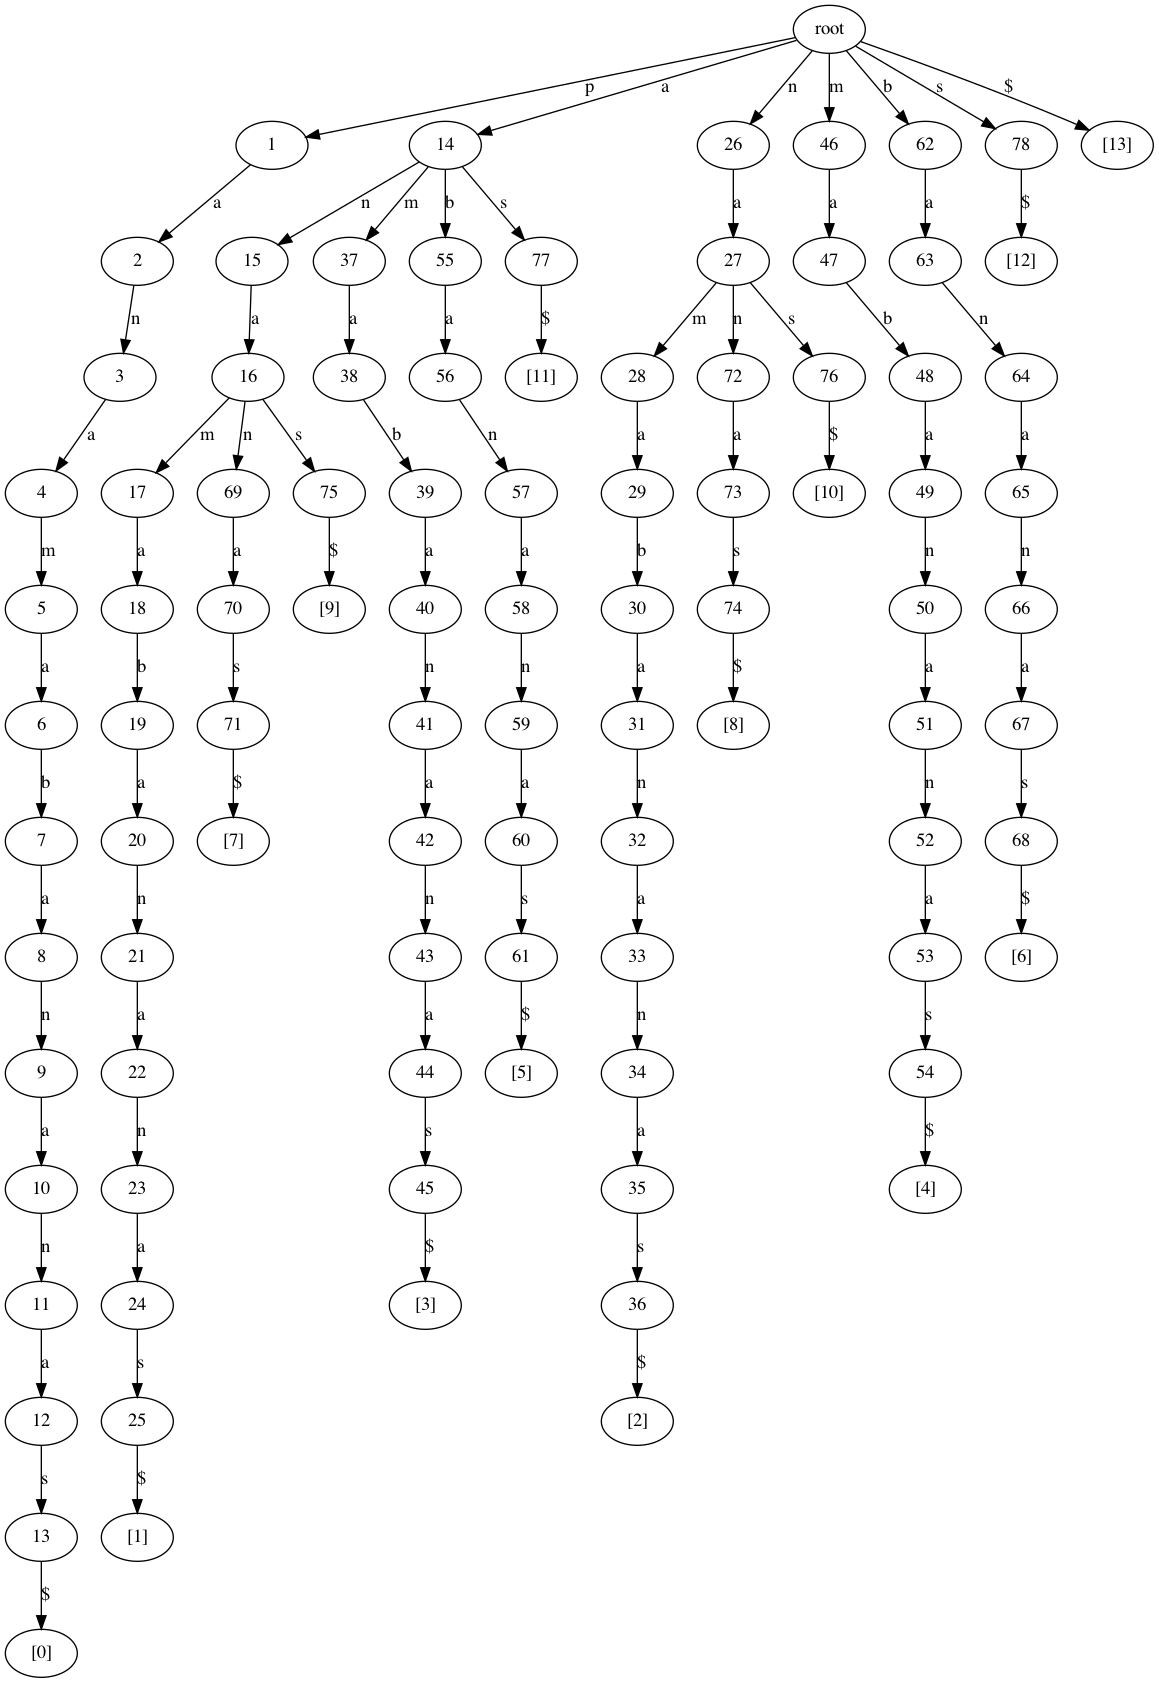

In [8]:
def suffix_trie(text):
    G = nx.DiGraph()
    G.add_node('root')
    # Your solution here
    return G

trie3 = suffix_trie("panamabananas$")
show(trie3)

One shortcoming with the suffix trie are the trivial edges (edges that just form a simple sequence with no branching). 

We can overcome this by producing a suffix tree that concatenates edges together when possible. 

There is a linear way to construct the suffix tree, but we will not do this in lab. Further, we would not store the simple sequence itself. We would store a pointer and a length.

We are going to keep things on a conceptual level. In other words, to solve the next exercise, don't worry about memory.

**Exercise 4:** Modified suffix trie construction

Input: A string ``text``

Output: Return a modified suffix trie as a networkx object using the method describe on page 515. 

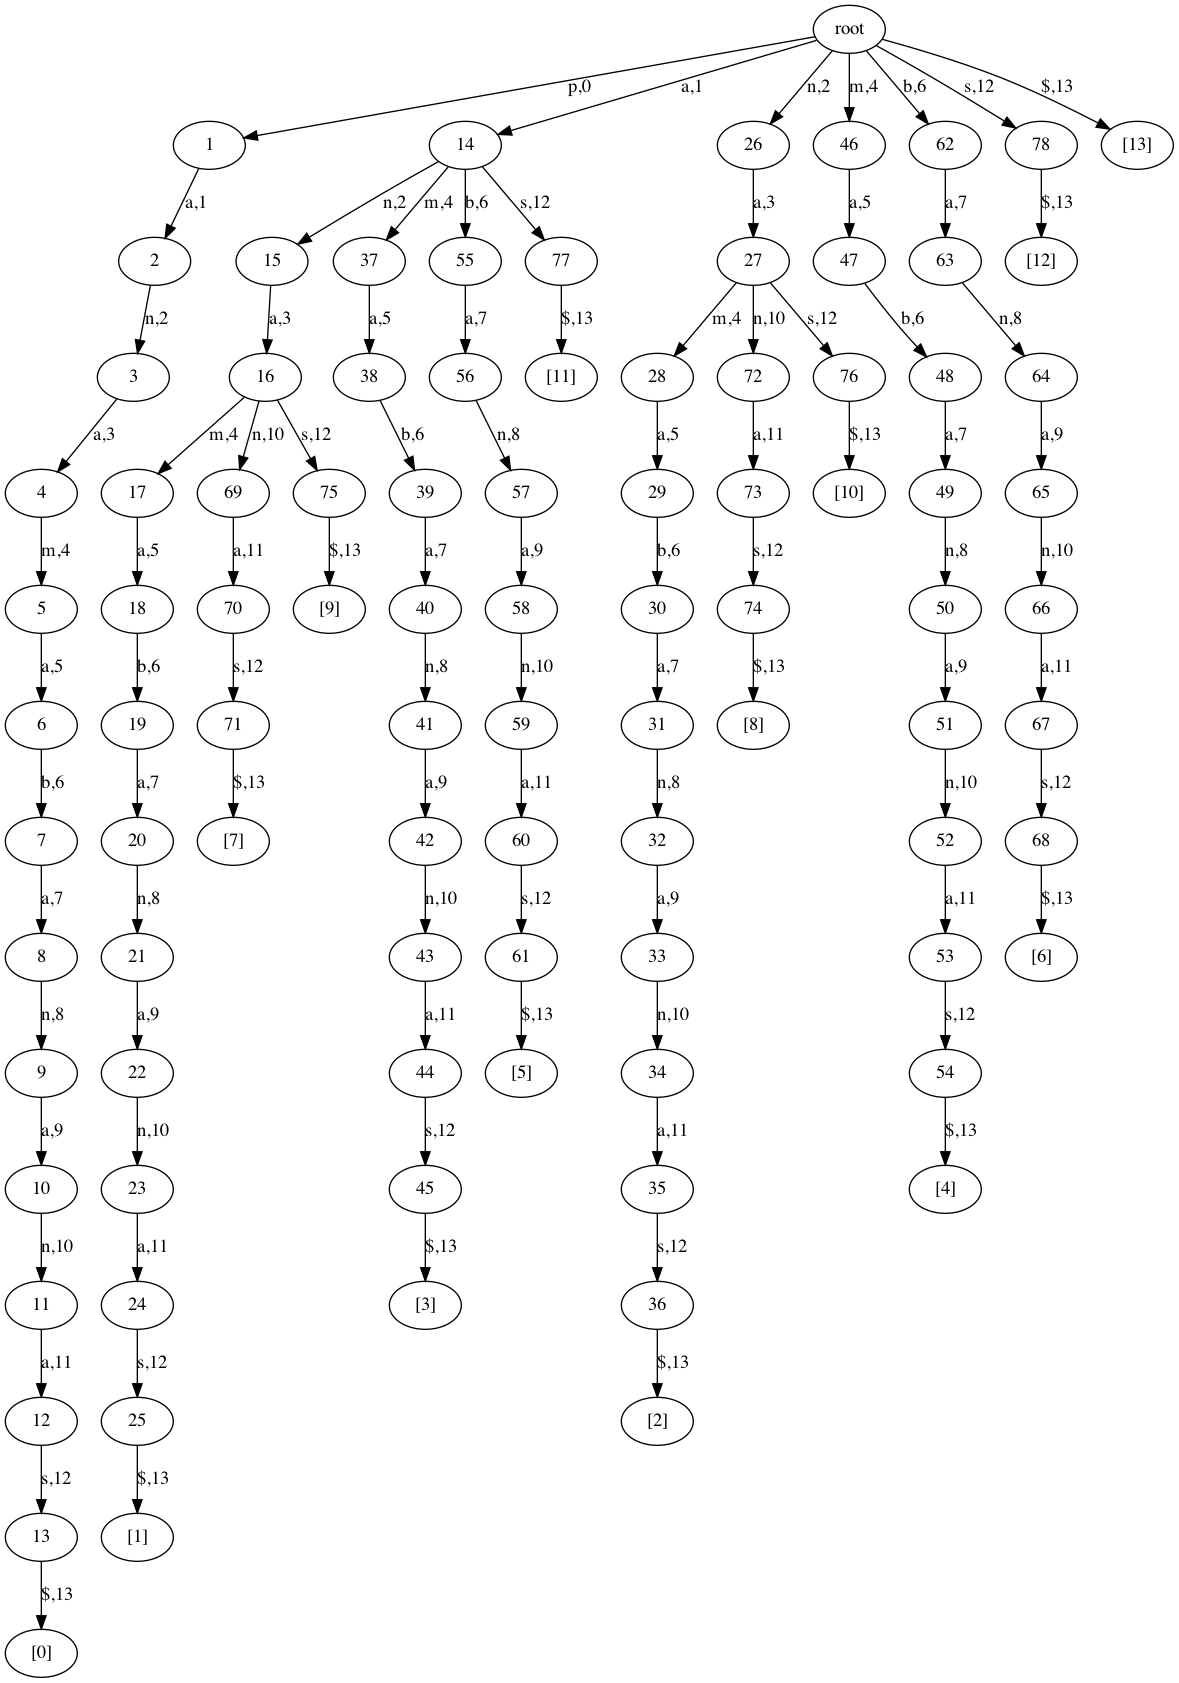

In [9]:
# Inputs: G - networkx graph, current - node name, c - character on edge
# Output: a neighbor of current that is reached by an edge that has label==c; otherwise None
def modified_find_edge(G,current,c):
    cv,j = c.split(",")
    j = int(j)
    for n in G.neighbors(current):
        if n is None:
            return None
        data = G.get_edge_data(current,n)
        cw,i = data['label'].split(",")
        i = int(i)
        if cw == cv and j > i:
            return n
    return None

def modified_suffix_trie(text):
    G = nx.DiGraph()
    G.add_node('root')
    leaf_nodes = []
    # Your solution here
    return G,leaf_nodes

trie4,leaf_nodes = modified_suffix_trie("panamabananas$")
show(trie4)

**Exercise 5:** Modified suffix trie construction

Input: A string ``text``

Output: Return a suffix tree using the method described starting on page 515. 

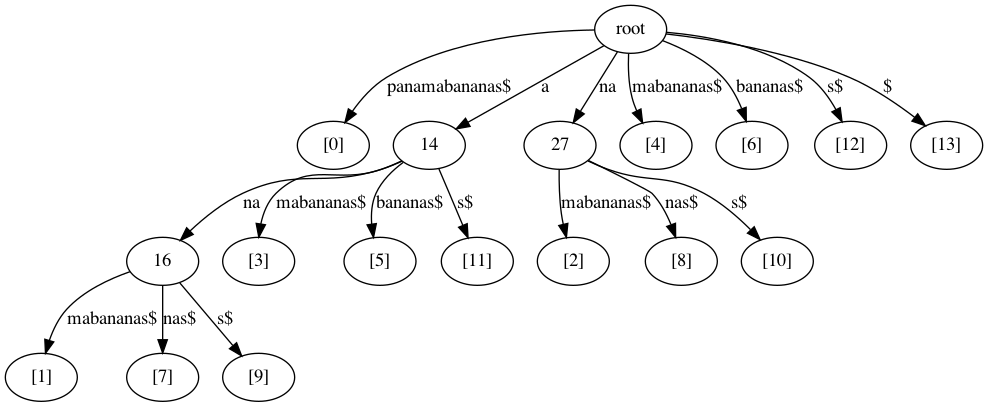

In [10]:
def suffix_tree_construction(text):
    trie,leaf_nodes = modified_suffix_trie(text)
    return trie

tree = suffix_tree_construction("panamabananas$")
show(tree)

In [11]:
# Don't forget to push!